# Anomaly Detection

This notebook covers the first part of the 8th exercise of the Machine Learning course at Coursera (the second part is on RecSys).

It focuses on implementing an anomaly detection algorithm using a Gaussian model and apply it to detect failing servers on a network.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import stats
%matplotlib inline

## Anomaly Detection Implementation

In [162]:
# Function that estimates the gaussian parameters mu and sigma of a given dataset X
# params:
# - X: data matrix [num_samples x num_features]
# returns:
# - mu: means of the features [num_features]
# - sigma2: sigma squared of the features [num_features]
def estimate_gaussian_params(X):
    mu = X.mean(axis=0)
    sigma2 = X.var(axis=0)
    
    return mu, sigma2

In [302]:
# Function that computes the probabilities (gaussian value) of each feature for each sample
# params:
# - X: data matrix [num_samples x num_features]
# - mu: means of the features [num_features]
# - sigma: sigmas of the features [num_features]
# returns:
# - prob: probablities (gaussian values)
def compute_gaussian_probabilities(X, mu, sigma):

    # compute gaussian value (using built-in norm function of scipy)
    prob = stats.norm(mu, sigma).pdf(X)
    
    # multiply all feature probabilities p(x) = p(x1)·p(x2)·...
    prob = np.prod(prob,axis=1);
    
    return np.matrix(prob).T

In [286]:
# Function that computes the best threshold value (maximizing F1 score on a labeled validation set)
# params
# - gaussian_probabilities: matrix of gaussian probabilities of each feature for each sample [num_samples x num_features] 
# - validation_labels: array of labels of the validation samples (not anomalous vs anomalous)
# returns:
# - epsilon: best found threshold value
def select_threshold(gaussian_probabilities, validation_labels):

    # init aux variables
    epsilon = 0
    best_f1 = 0
    step = (gaussian_probabilities.max() - gaussian_probabilities.min()) / 1000

    # loop all epsilon step values
    for e in np.arange(gaussian_probabilities.min(), gaussian_probabilities.max(), step):
        
        # compute predictions
        prediction_labels = gaussian_probabilities < e
        
        # compute TP, FP and FN
        tp = np.sum(np.logical_and(prediction_labels == True, validation_labels == 1)).astype(float)
        fp = np.sum(np.logical_and(prediction_labels == True, validation_labels == 0)).astype(float)
        fn = np.sum(np.logical_and(prediction_labels == False, validation_labels == 1)).astype(float)
        
        # compute precision and recall
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        # compute F1 score
        f1 = (2 * precision * recall) / (precision + recall)
        
        # update best f1 and best epsilon, if it applies
        if f1 > best_f1:
            best_f1 = f1
            epsilon = e
            
    return epsilon

## Anomaly detection in simple data set

In this first exercise we have 307 samples with features of throughput (mb/s) and latency (ms). This simple 2D dataset will help us understand how the AD algorithm works.

In [297]:
# load (unlabeled) data
X = loadmat('ex8data1.mat')['X']
X.shape

(307, 2)

In [298]:
# load (labeled) validation data (used to compute F1 score ans select the threshold value)
X_val = loadmat('ex8data1.mat')['Xval']
print(X_val.shape)
y_val = loadmat('ex8data1.mat')['yval']
print(y_val.shape)

(307, 2)
(307, 1)


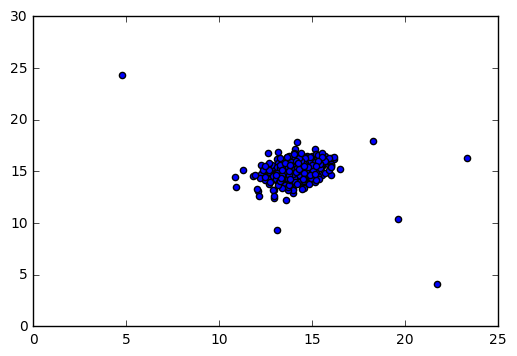

In [299]:
# Visually explore the data
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(X[:,0], X[:,1])

There are clearly some anomalous servers...

In [300]:
# estimate the gaussian parameters
mu, sigma2 = estimate_gaussian_params(X)

In [303]:
# compute the gaussian value of each feature for each sample (probabilities p(x1), p(x2),... )
gaussian_probabilities = compute_gaussian_probabilities(X, mu, sigma2)
gaussian_probabilities_val = compute_gaussian_probabilities(X_val, mu, sigma2)

In [304]:
# compute epsilon threshold
epsilon = select_threshold(gaussian_probabilities_val, y_val)
epsilon

0.00045713740891134883

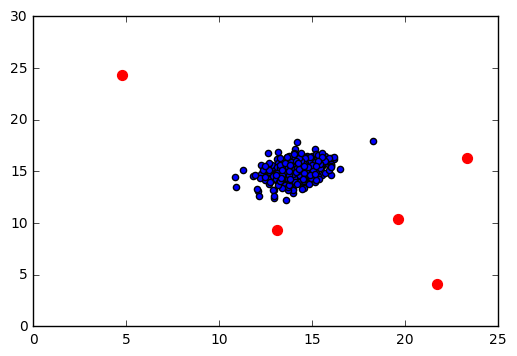

In [305]:
# get anomalies and plot them
anomalies = np.where(gaussian_probabilities < epsilon)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[anomalies[0],0], X[anomalies[0],1], s=50, color='r', marker='o')

## Anomaly detection in complex data set

In this second exercise we have 1000 samples with 11 features.

In [306]:
# load (unlabeled) data
X = loadmat('ex8data2.mat')['X']
X.shape

(1000, 11)

In [307]:
# load (labeled) validation data (used to compute F1 score ans select the threshold value)
X_val = loadmat('ex8data2.mat')['Xval']
print(X_val.shape)
y_val = loadmat('ex8data2.mat')['yval']
print(y_val.shape)

(100, 11)
(100, 1)


In [308]:
# estimate the gaussian parameters
mu, sigma = estimate_gaussian_params(X)

In [309]:
# compute the gaussian value of each feature for each sample (probabilities p(x1), p(x2),... )
gaussian_probabilities = compute_gaussian_probabilities(X, mu, sigma)
gaussian_probabilities_val = compute_gaussian_probabilities(X_val, mu, sigma)

In [310]:
# compute epsilon threshold
epsilon = select_threshold(gaussian_probabilities_val, y_val)
epsilon

7.1428233069041263e-25

In [318]:
# get the anomalies and count them
anomalies = np.where(gaussian_probabilities < epsilon)
print('num anomalies: ', len(anomalies[0]))

num anomalies:  55
